In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

C:\anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("data.csv")
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.drop(["id"], axis = 1, inplace = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10110 entries, 0 to 10109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10110 non-null  object 
 1   age                10110 non-null  float64
 2   hypertension       10110 non-null  int64  
 3   heart_disease      10110 non-null  int64  
 4   ever_married       10110 non-null  object 
 5   work_type          10110 non-null  object 
 6   Residence_type     10110 non-null  object 
 7   avg_glucose_level  10110 non-null  float64
 8   bmi                9200 non-null   float64
 9   smoking_status     10110 non-null  object 
 10  stroke             10110 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 869.0+ KB


In [5]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  910
smoking_status         0
stroke                 0
dtype: int64

In [6]:
gender = df.iloc[:,0:1].values
ever_married = df.iloc[:,4].values  
work_type = df.iloc[:,5:6].values
residence_type = df.iloc[:,6].values 
smoking_status = df.iloc[:,9:10].values

In [7]:
age = df[["age"]]
hypertension = df[["hypertension"]]
heart_disease = df[["heart_disease"]]
avg_glucose_level = df[["avg_glucose_level"]]
bmi = df[["bmi"]]
stroke = df[["stroke"]]

In [8]:
unique, counts = np.unique(ever_married, return_counts = True)
print(np.asarray((unique, counts)).T)

[['No' 3535]
 ['Yes' 6575]]


In [9]:
# Label Encoding for ever_married and residence_type columns which has two labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ever_married = le.fit_transform(ever_married)
ever_married = pd.DataFrame(ever_married, columns = ["ever_married"])
print("Labels 0, 1:",le.classes_)
residence_type = le.fit_transform(residence_type)
residence_type = pd.DataFrame(residence_type, columns = ["residence_type"])
print("Labels 0, 1:",le.classes_)

Labels 0, 1: ['No' 'Yes']
Labels 0, 1: ['Rural' 'Urban']


In [10]:
ohe = OneHotEncoder(dtype = np.int64, sparse = False)
gender = ohe.fit_transform(gender)
gender = pd.DataFrame(gender, columns = ['female', 'male', 'other'])
print("Gender dummies respectively 0, 1, 2:", ohe.categories_)
work_type = ohe.fit_transform(work_type)
work_type = pd.DataFrame(work_type, columns = ['govt_job', 'never_worked', 'private', 'self-employed', 'children'])
print("Work type dummies respectively 0, 1, 2, 3, 4:", ohe.categories_)
smoking_status = ohe.fit_transform(smoking_status)
smoking_status = pd.DataFrame(smoking_status, columns = ['unknown', 'formerly_smoked', 'never_smoked', 'smokes'])
print("Smoking status dummies respectively 0, 1, 2, 3:", ohe.categories_)

Gender dummies respectively 0, 1, 2: [array(['Female', 'Male', 'Other'], dtype=object)]
Work type dummies respectively 0, 1, 2, 3, 4: [array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype=object)]
Smoking status dummies respectively 0, 1, 2, 3: [array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype=object)]


In [11]:
frames = [gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, avg_glucose_level, bmi, smoking_status, stroke]
df_en = pd.concat(frames, axis = 1)
df_en.head(3)

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0,1,0,67.0,0,1,1,0,0,1,0,0,1,228.69,36.6,0,1,0,0,1
1,1,0,0,61.0,0,0,1,0,0,0,1,0,0,202.21,NaN,0,0,1,0,1
2,0,1,0,80.0,0,1,1,0,0,1,0,0,0,105.92,32.5,0,0,1,0,1


In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
df_en = pd.DataFrame(imputer.fit_transform(df_en), columns = df_en.columns)
df_en.head()

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0.0,1.0,0.0,67.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,228.69,36.600000,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,61.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,202.21,29.701435,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,105.92,32.500000,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,49.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,171.23,34.400000,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,79.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,174.12,24.000000,0.0,0.0,1.0,0.0,1.0


In [13]:
int_vars = ["female","male","other","age","hypertension","heart_disease","ever_married","govt_job","never_worked","private","self-employed", 
            "children", "residence_type","unknown","formerly_smoked","never_smoked","smokes"]

df1 = df_en[int_vars].astype(np.int64)
num_vars = ["avg_glucose_level","bmi"]
df2 = df_en[num_vars]
label = ["stroke"]
df3 = df_en[label]
df_en = pd.concat([df1, df2, df3], axis = 1)
df_en

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,unknown,formerly_smoked,never_smoked,smokes,avg_glucose_level,bmi,stroke
0,0,1,0,67,0,1,1,0,0,1,0,0,1,0,1,0,0,228.69,36.600000,1.0
1,1,0,0,61,0,0,1,0,0,0,1,0,0,0,0,1,0,202.21,29.701435,1.0
2,0,1,0,80,0,1,1,0,0,1,0,0,0,0,0,1,0,105.92,32.500000,1.0
3,1,0,0,49,0,0,1,0,0,1,0,0,1,0,0,0,1,171.23,34.400000,1.0
4,1,0,0,79,1,0,1,0,0,0,1,0,0,0,0,1,0,174.12,24.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10105,1,0,0,18,0,0,1,0,0,0,1,0,1,0,1,0,0,65.38,25.100000,0.0
10106,0,1,0,17,0,0,0,1,0,0,0,0,1,0,0,1,0,89.57,29.701435,0.0
10107,0,1,0,26,0,0,0,0,0,1,0,0,1,0,0,1,0,140.93,21.000000,0.0
10108,1,0,0,5,0,0,1,0,0,1,0,0,1,1,0,0,0,197.11,29.701435,0.0


In [14]:
df_en.isnull().sum()

female               0
male                 0
other                0
age                  0
hypertension         0
heart_disease        0
ever_married         0
govt_job             0
never_worked         0
private              0
self-employed        0
children             0
residence_type       0
unknown              0
formerly_smoked      0
never_smoked         0
smokes               0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

In [15]:
y = df_en.stroke
X = df_en.drop(['stroke'], axis=1)

In [16]:
from imblearn.over_sampling import SMOTE
#X, y = df_en.iloc[:, 0:-1], df_en.iloc[:, -1:]

#print("Before Oversampling, the counts of label 1: ", y.value_counts()[1])
#print("Before Oversampling, the counts of label 0: ", y.value_counts()[0])

oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

print("After Oversampling, the counts of label 1: ", y.value_counts()[1])
print("After Oversampling, the counts of label 0: ", y.value_counts()[0])

Using TensorFlow backend.


After Oversampling, the counts of label 1:  9446
After Oversampling, the counts of label 0:  9446


In [17]:
# Splitting data to validation and training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scaling features between -1 and 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Model:  Random Forest
Validation Accuracy:  0.9581899973537973
Training Accuracy:  1.0


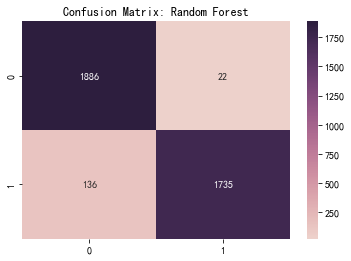

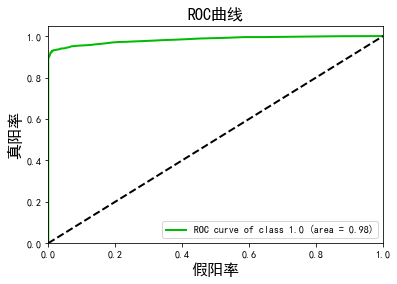

[20:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model:  XG Boost
Validation Accuracy:  0.951045250066155
Training Accuracy:  0.9851783232978231


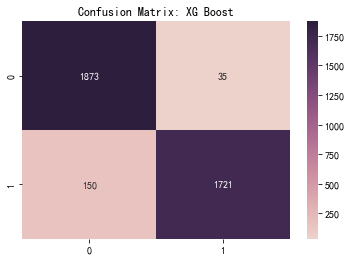

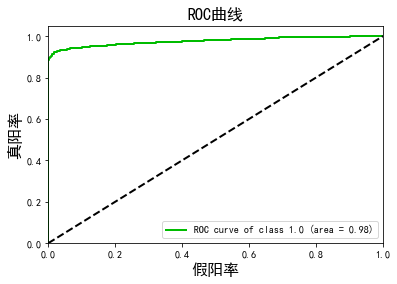

Model:  Cat Boost
Validation Accuracy:  0.9491929081767664
Training Accuracy:  0.9701581419969563


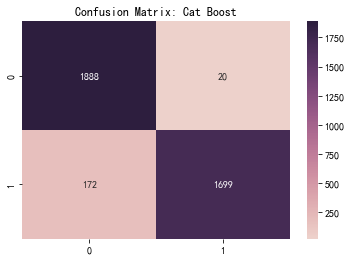

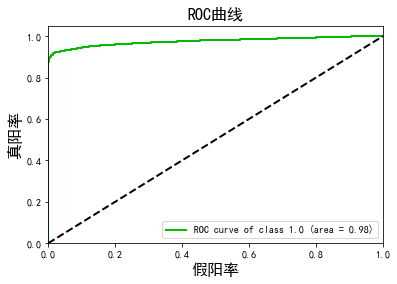

In [22]:
# Models to be used for ML
models = [#('Logistic Regression', LogisticRegression()),
          #('Decision Tree Classifier', DecisionTreeClassifier()),
          ('Random Forest', RandomForestClassifier()),
          #('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          #('Ada Boost', AdaBoostClassifier()),
          #('KNN', KNeighborsClassifier()),
          #('Support Vector Classifier', SVC(probability = True)),
          ('XG Boost', XGBClassifier()),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent'))]
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
models_score = []
for name, model in models:
    model = model
    model.fit(x_train, y_train)
    model.predict(x_test)
    models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
    
    print("Model: ",name)
    print('Validation Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
    print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
    
    plt.figure()
    cf_matrix = confusion_matrix(y_test, model.predict(x_test))
    plt.title('Confusion Matrix: {}'.format(name))
    sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
    plt.show()
    
    import scikitplot as skplt
    font = {'weight':'normal','size':16}
    skplt.metrics.plot_roc(y_test, model.predict_proba(x_test),
                         classes_to_plot=True,
                         figsize=(6, 4),
                        plot_micro=False, plot_macro=False)
    plt.title('ROC曲线',font)
    plt.xlabel('假阳率',font)
    plt.ylabel('真阳率',font)
    plt.savefig("name{}.png".format(name),dpi=200)
    plt.show()   

In [ ]:
plt.figure(figsize = (12, 6))
sns.barplot(x = np.array(models_score)[:, 0], y=np.array(models_score)[:, 1].astype('float64'))
plt.xticks(rotation = 45);

超参数调优

In [24]:
# Models with hyperparameters to be tuned
grid_models = [#(LogisticRegression(),[{'C' : [0.3, 0.7, 1], 'random_state' : [42]}]),
               #(DecisionTreeClassifier(),[{'criterion' : ['gini','entropy'], 'random_state' : [42]}]),
               (RandomForestClassifier(),[{'n_estimators' : [100, 200, 300], 'criterion' : ['gini','entropy'], 'random_state' : [42]}]),
               #(LinearDiscriminantAnalysis(),[{'solver' : ['svd', 'lsqr', 'eigen']}]),
               #(AdaBoostClassifier(),[{'n_estimators' : [50, 100, 150], 'random_state' : [42]}]),
               #(KNeighborsClassifier(),[{'n_neighbors' : [4, 6, 8, 10], 'metric' : ['euclidean', 'manhattan', 'chebyshev','minkowski']}]),
               #(SVC(),[{'C' : [0.3, 0.7, 1], 'kernel' : ['rbf','linear','polynomial'], 'random_state' : [42]}]),
               (XGBClassifier(),[{'max_depth' : [3, 5, 7], 'min_child_weight' : [1, 3, 5]}]),
               (CatBoostClassifier(),[{'n_estimators' : [100, 200, 300], 'max_depth' : [3,5,7]}])]

In [25]:
for model, param_grid  in grid_models:
    cv = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = 5)
    cv.fit(x_train, y_train)
    best_accuracy = cv.best_score_
    best_params = cv.best_params_
    print('{}: \nBest Accuracy: {:.2f}%'.format(model, best_accuracy*100))
    print('Best Parameters: ',best_params)
    print('******************************')

RandomForestClassifier(): 
Best Accuracy: 96.09%
Best Parameters:  {'criterion': 'gini', 'n_estimators': 100, 'random_state': 42}
******************************
[21:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from '

[21:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

64:	learn: 0.2051566	total: 200ms	remaining: 108ms
65:	learn: 0.2045188	total: 204ms	remaining: 105ms
66:	learn: 0.2041033	total: 206ms	remaining: 102ms
67:	learn: 0.2033877	total: 211ms	remaining: 99.4ms
68:	learn: 0.2022606	total: 214ms	remaining: 96ms
69:	learn: 0.2014217	total: 216ms	remaining: 92.6ms
70:	learn: 0.2009695	total: 218ms	remaining: 89.1ms
71:	learn: 0.2004276	total: 221ms	remaining: 85.8ms
72:	learn: 0.2002332	total: 227ms	remaining: 83.8ms
73:	learn: 0.1999441	total: 230ms	remaining: 80.9ms
74:	learn: 0.1995196	total: 232ms	remaining: 77.5ms
75:	learn: 0.1990532	total: 236ms	remaining: 74.4ms
76:	learn: 0.1983315	total: 243ms	remaining: 72.7ms
77:	learn: 0.1977274	total: 246ms	remaining: 69.5ms
78:	learn: 0.1974441	total: 249ms	remaining: 66.1ms
79:	learn: 0.1963655	total: 251ms	remaining: 62.7ms
80:	learn: 0.1958250	total: 253ms	remaining: 59.5ms
81:	learn: 0.1955129	total: 257ms	remaining: 56.3ms
82:	learn: 0.1952034	total: 259ms	remaining: 53ms
83:	learn: 0.194772

46:	learn: 0.2247018	total: 176ms	remaining: 198ms
47:	learn: 0.2226306	total: 179ms	remaining: 194ms
48:	learn: 0.2214943	total: 189ms	remaining: 197ms
49:	learn: 0.2203329	total: 194ms	remaining: 194ms
50:	learn: 0.2197043	total: 199ms	remaining: 191ms
51:	learn: 0.2177806	total: 205ms	remaining: 189ms
52:	learn: 0.2168283	total: 210ms	remaining: 186ms
53:	learn: 0.2160921	total: 218ms	remaining: 186ms
54:	learn: 0.2151077	total: 225ms	remaining: 184ms
55:	learn: 0.2136149	total: 232ms	remaining: 182ms
56:	learn: 0.2129398	total: 241ms	remaining: 182ms
57:	learn: 0.2121933	total: 245ms	remaining: 177ms
58:	learn: 0.2117735	total: 254ms	remaining: 176ms
59:	learn: 0.2091128	total: 257ms	remaining: 172ms
60:	learn: 0.2083394	total: 264ms	remaining: 169ms
61:	learn: 0.2071053	total: 267ms	remaining: 164ms
62:	learn: 0.2062987	total: 272ms	remaining: 160ms
63:	learn: 0.2049171	total: 280ms	remaining: 158ms
64:	learn: 0.2042526	total: 284ms	remaining: 153ms
65:	learn: 0.2038293	total: 286

59:	learn: 0.2057957	total: 165ms	remaining: 110ms
60:	learn: 0.2055308	total: 167ms	remaining: 107ms
61:	learn: 0.2050111	total: 169ms	remaining: 104ms
62:	learn: 0.2035951	total: 172ms	remaining: 101ms
63:	learn: 0.2029644	total: 175ms	remaining: 98.2ms
64:	learn: 0.2024481	total: 178ms	remaining: 95.7ms
65:	learn: 0.2004668	total: 181ms	remaining: 93.1ms
66:	learn: 0.2001640	total: 183ms	remaining: 90.1ms
67:	learn: 0.1995307	total: 185ms	remaining: 87.2ms
68:	learn: 0.1983941	total: 188ms	remaining: 84.3ms
69:	learn: 0.1975322	total: 191ms	remaining: 81.7ms
70:	learn: 0.1970821	total: 193ms	remaining: 78.8ms
71:	learn: 0.1968683	total: 195ms	remaining: 75.8ms
72:	learn: 0.1962417	total: 197ms	remaining: 73ms
73:	learn: 0.1955612	total: 200ms	remaining: 70.3ms
74:	learn: 0.1949563	total: 202ms	remaining: 67.4ms
75:	learn: 0.1946746	total: 206ms	remaining: 64.9ms
76:	learn: 0.1940227	total: 209ms	remaining: 62.3ms
77:	learn: 0.1936165	total: 211ms	remaining: 59.5ms
78:	learn: 0.19282

122:	learn: 0.1937751	total: 927ms	remaining: 580ms
123:	learn: 0.1934159	total: 936ms	remaining: 574ms
124:	learn: 0.1931484	total: 942ms	remaining: 565ms
125:	learn: 0.1928880	total: 948ms	remaining: 557ms
126:	learn: 0.1925494	total: 954ms	remaining: 548ms
127:	learn: 0.1919848	total: 960ms	remaining: 540ms
128:	learn: 0.1916564	total: 966ms	remaining: 532ms
129:	learn: 0.1911297	total: 971ms	remaining: 523ms
130:	learn: 0.1907477	total: 979ms	remaining: 516ms
131:	learn: 0.1903817	total: 985ms	remaining: 507ms
132:	learn: 0.1900263	total: 991ms	remaining: 499ms
133:	learn: 0.1897797	total: 1s	remaining: 493ms
134:	learn: 0.1894501	total: 1s	remaining: 484ms
135:	learn: 0.1891397	total: 1.01s	remaining: 476ms
136:	learn: 0.1879155	total: 1.02s	remaining: 468ms
137:	learn: 0.1876986	total: 1.02s	remaining: 461ms
138:	learn: 0.1875446	total: 1.03s	remaining: 453ms
139:	learn: 0.1873726	total: 1.04s	remaining: 447ms
140:	learn: 0.1871118	total: 1.05s	remaining: 439ms
141:	learn: 0.1867

95:	learn: 0.2131372	total: 726ms	remaining: 786ms
96:	learn: 0.2126442	total: 734ms	remaining: 779ms
97:	learn: 0.2120561	total: 741ms	remaining: 771ms
98:	learn: 0.2117130	total: 747ms	remaining: 762ms
99:	learn: 0.2093448	total: 753ms	remaining: 753ms
100:	learn: 0.2089996	total: 761ms	remaining: 746ms
101:	learn: 0.2085996	total: 769ms	remaining: 739ms
102:	learn: 0.2081530	total: 776ms	remaining: 731ms
103:	learn: 0.2077689	total: 786ms	remaining: 725ms
104:	learn: 0.2071501	total: 793ms	remaining: 718ms
105:	learn: 0.2068143	total: 800ms	remaining: 709ms
106:	learn: 0.2060882	total: 808ms	remaining: 702ms
107:	learn: 0.2056557	total: 814ms	remaining: 693ms
108:	learn: 0.2053613	total: 820ms	remaining: 685ms
109:	learn: 0.2046296	total: 828ms	remaining: 678ms
110:	learn: 0.2042842	total: 836ms	remaining: 671ms
111:	learn: 0.2039640	total: 843ms	remaining: 662ms
112:	learn: 0.2035509	total: 852ms	remaining: 656ms
113:	learn: 0.2031282	total: 858ms	remaining: 648ms
114:	learn: 0.202

77:	learn: 0.2218134	total: 541ms	remaining: 846ms
78:	learn: 0.2207508	total: 548ms	remaining: 839ms
79:	learn: 0.2202264	total: 555ms	remaining: 832ms
80:	learn: 0.2195714	total: 559ms	remaining: 822ms
81:	learn: 0.2191167	total: 567ms	remaining: 817ms
82:	learn: 0.2185331	total: 573ms	remaining: 808ms
83:	learn: 0.2176943	total: 579ms	remaining: 800ms
84:	learn: 0.2170905	total: 588ms	remaining: 795ms
85:	learn: 0.2164059	total: 593ms	remaining: 787ms
86:	learn: 0.2155949	total: 605ms	remaining: 785ms
87:	learn: 0.2151709	total: 613ms	remaining: 780ms
88:	learn: 0.2147664	total: 621ms	remaining: 774ms
89:	learn: 0.2120311	total: 631ms	remaining: 771ms
90:	learn: 0.2116676	total: 640ms	remaining: 766ms
91:	learn: 0.2110396	total: 646ms	remaining: 758ms
92:	learn: 0.2107495	total: 654ms	remaining: 752ms
93:	learn: 0.2103350	total: 661ms	remaining: 746ms
94:	learn: 0.2099016	total: 672ms	remaining: 743ms
95:	learn: 0.2090759	total: 678ms	remaining: 735ms
96:	learn: 0.2085308	total: 684

44:	learn: 0.2605861	total: 379ms	remaining: 1.3s
45:	learn: 0.2591124	total: 390ms	remaining: 1.3s
46:	learn: 0.2581306	total: 397ms	remaining: 1.29s
47:	learn: 0.2565688	total: 411ms	remaining: 1.3s
48:	learn: 0.2556005	total: 418ms	remaining: 1.29s
49:	learn: 0.2544060	total: 426ms	remaining: 1.28s
50:	learn: 0.2531883	total: 434ms	remaining: 1.27s
51:	learn: 0.2518816	total: 443ms	remaining: 1.26s
52:	learn: 0.2471500	total: 452ms	remaining: 1.25s
53:	learn: 0.2463544	total: 469ms	remaining: 1.27s
54:	learn: 0.2443894	total: 477ms	remaining: 1.26s
55:	learn: 0.2435053	total: 488ms	remaining: 1.25s
56:	learn: 0.2425232	total: 498ms	remaining: 1.25s
57:	learn: 0.2418182	total: 506ms	remaining: 1.24s
58:	learn: 0.2408921	total: 514ms	remaining: 1.23s
59:	learn: 0.2390543	total: 524ms	remaining: 1.22s
60:	learn: 0.2373634	total: 533ms	remaining: 1.21s
61:	learn: 0.2365762	total: 546ms	remaining: 1.21s
62:	learn: 0.2359495	total: 560ms	remaining: 1.22s
63:	learn: 0.2350313	total: 570ms	

23:	learn: 0.3137437	total: 180ms	remaining: 1.32s
24:	learn: 0.3091686	total: 187ms	remaining: 1.31s
25:	learn: 0.3064617	total: 196ms	remaining: 1.31s
26:	learn: 0.3039687	total: 202ms	remaining: 1.3s
27:	learn: 0.3010693	total: 210ms	remaining: 1.29s
28:	learn: 0.2968255	total: 216ms	remaining: 1.27s
29:	learn: 0.2930585	total: 228ms	remaining: 1.29s
30:	learn: 0.2832827	total: 234ms	remaining: 1.28s
31:	learn: 0.2813306	total: 245ms	remaining: 1.28s
32:	learn: 0.2795725	total: 256ms	remaining: 1.29s
33:	learn: 0.2767888	total: 263ms	remaining: 1.29s
34:	learn: 0.2738297	total: 272ms	remaining: 1.28s
35:	learn: 0.2722522	total: 280ms	remaining: 1.27s
36:	learn: 0.2701056	total: 287ms	remaining: 1.26s
37:	learn: 0.2689240	total: 294ms	remaining: 1.25s
38:	learn: 0.2673900	total: 301ms	remaining: 1.24s
39:	learn: 0.2645065	total: 310ms	remaining: 1.24s
40:	learn: 0.2588604	total: 322ms	remaining: 1.25s
41:	learn: 0.2578937	total: 330ms	remaining: 1.24s
42:	learn: 0.2537482	total: 338m

Learning rate set to 0.090076
0:	learn: 0.6334935	total: 10.2ms	remaining: 3.04s
1:	learn: 0.6115150	total: 61.7ms	remaining: 9.2s
2:	learn: 0.5877171	total: 80.6ms	remaining: 7.98s
3:	learn: 0.5690629	total: 101ms	remaining: 7.51s
4:	learn: 0.5512008	total: 117ms	remaining: 6.89s
5:	learn: 0.5322376	total: 133ms	remaining: 6.51s
6:	learn: 0.5002425	total: 146ms	remaining: 6.09s
7:	learn: 0.4923003	total: 164ms	remaining: 6s
8:	learn: 0.4776102	total: 181ms	remaining: 5.85s
9:	learn: 0.4651723	total: 188ms	remaining: 5.44s
10:	learn: 0.4587734	total: 200ms	remaining: 5.24s
11:	learn: 0.4483141	total: 205ms	remaining: 4.92s
12:	learn: 0.4380586	total: 215ms	remaining: 4.74s
13:	learn: 0.4303161	total: 221ms	remaining: 4.51s
14:	learn: 0.4225223	total: 231ms	remaining: 4.39s
15:	learn: 0.4157866	total: 237ms	remaining: 4.2s
16:	learn: 0.4096095	total: 246ms	remaining: 4.09s
17:	learn: 0.4011466	total: 252ms	remaining: 3.94s
18:	learn: 0.3847065	total: 263ms	remaining: 3.89s
19:	learn: 0.

183:	learn: 0.1936213	total: 1.68s	remaining: 1.06s
184:	learn: 0.1932460	total: 1.68s	remaining: 1.04s
185:	learn: 0.1930090	total: 1.69s	remaining: 1.03s
186:	learn: 0.1928326	total: 1.7s	remaining: 1.02s
187:	learn: 0.1924659	total: 1.7s	remaining: 1.01s
188:	learn: 0.1922652	total: 1.71s	remaining: 1s
189:	learn: 0.1921222	total: 1.71s	remaining: 993ms
190:	learn: 0.1917788	total: 1.72s	remaining: 983ms
191:	learn: 0.1916126	total: 1.73s	remaining: 972ms
192:	learn: 0.1914408	total: 1.74s	remaining: 964ms
193:	learn: 0.1912389	total: 1.74s	remaining: 953ms
194:	learn: 0.1910272	total: 1.75s	remaining: 943ms
195:	learn: 0.1908045	total: 1.76s	remaining: 933ms
196:	learn: 0.1904758	total: 1.76s	remaining: 922ms
197:	learn: 0.1902866	total: 1.77s	remaining: 913ms
198:	learn: 0.1900256	total: 1.78s	remaining: 902ms
199:	learn: 0.1898505	total: 1.79s	remaining: 894ms
200:	learn: 0.1896741	total: 1.79s	remaining: 883ms
201:	learn: 0.1894972	total: 1.8s	remaining: 876ms
202:	learn: 0.1893

45:	learn: 0.2871320	total: 359ms	remaining: 1.98s
46:	learn: 0.2861197	total: 365ms	remaining: 1.97s
47:	learn: 0.2837064	total: 372ms	remaining: 1.96s
48:	learn: 0.2814651	total: 378ms	remaining: 1.93s
49:	learn: 0.2799061	total: 386ms	remaining: 1.93s
50:	learn: 0.2784833	total: 394ms	remaining: 1.92s
51:	learn: 0.2771540	total: 399ms	remaining: 1.9s
52:	learn: 0.2760953	total: 410ms	remaining: 1.91s
53:	learn: 0.2741405	total: 419ms	remaining: 1.91s
54:	learn: 0.2731062	total: 426ms	remaining: 1.9s
55:	learn: 0.2721463	total: 434ms	remaining: 1.89s
56:	learn: 0.2708587	total: 440ms	remaining: 1.87s
57:	learn: 0.2693030	total: 445ms	remaining: 1.86s
58:	learn: 0.2685299	total: 456ms	remaining: 1.86s
59:	learn: 0.2676066	total: 461ms	remaining: 1.84s
60:	learn: 0.2662672	total: 469ms	remaining: 1.84s
61:	learn: 0.2647468	total: 474ms	remaining: 1.82s
62:	learn: 0.2640002	total: 482ms	remaining: 1.81s
63:	learn: 0.2629478	total: 487ms	remaining: 1.8s
64:	learn: 0.2622427	total: 498ms	

228:	learn: 0.1875773	total: 1.85s	remaining: 575ms
229:	learn: 0.1874052	total: 1.86s	remaining: 567ms
230:	learn: 0.1872695	total: 1.87s	remaining: 558ms
231:	learn: 0.1870473	total: 1.88s	remaining: 550ms
232:	learn: 0.1868984	total: 1.88s	remaining: 541ms
233:	learn: 0.1867612	total: 1.89s	remaining: 534ms
234:	learn: 0.1864446	total: 1.9s	remaining: 525ms
235:	learn: 0.1862910	total: 1.91s	remaining: 517ms
236:	learn: 0.1861199	total: 1.91s	remaining: 509ms
237:	learn: 0.1859693	total: 1.93s	remaining: 502ms
238:	learn: 0.1858329	total: 1.93s	remaining: 494ms
239:	learn: 0.1855599	total: 1.94s	remaining: 485ms
240:	learn: 0.1853586	total: 1.95s	remaining: 477ms
241:	learn: 0.1852023	total: 1.96s	remaining: 469ms
242:	learn: 0.1849772	total: 1.96s	remaining: 460ms
243:	learn: 0.1847361	total: 1.97s	remaining: 452ms
244:	learn: 0.1846042	total: 1.98s	remaining: 444ms
245:	learn: 0.1845037	total: 1.99s	remaining: 436ms
246:	learn: 0.1842867	total: 1.99s	remaining: 428ms
247:	learn: 0

87:	learn: 0.2391257	total: 727ms	remaining: 1.75s
88:	learn: 0.2386383	total: 739ms	remaining: 1.75s
89:	learn: 0.2379968	total: 749ms	remaining: 1.75s
90:	learn: 0.2368578	total: 755ms	remaining: 1.74s
91:	learn: 0.2359114	total: 765ms	remaining: 1.73s
92:	learn: 0.2354681	total: 776ms	remaining: 1.73s
93:	learn: 0.2349533	total: 785ms	remaining: 1.72s
94:	learn: 0.2345185	total: 799ms	remaining: 1.72s
95:	learn: 0.2336130	total: 807ms	remaining: 1.72s
96:	learn: 0.2331417	total: 816ms	remaining: 1.71s
97:	learn: 0.2321166	total: 830ms	remaining: 1.71s
98:	learn: 0.2316263	total: 839ms	remaining: 1.7s
99:	learn: 0.2312150	total: 849ms	remaining: 1.7s
100:	learn: 0.2306063	total: 863ms	remaining: 1.7s
101:	learn: 0.2300200	total: 870ms	remaining: 1.69s
102:	learn: 0.2295160	total: 881ms	remaining: 1.69s
103:	learn: 0.2290867	total: 894ms	remaining: 1.69s
104:	learn: 0.2285226	total: 900ms	remaining: 1.67s
105:	learn: 0.2281190	total: 913ms	remaining: 1.67s
106:	learn: 0.2261750	total:

262:	learn: 0.1795868	total: 2.39s	remaining: 336ms
263:	learn: 0.1788497	total: 2.4s	remaining: 327ms
264:	learn: 0.1787694	total: 2.4s	remaining: 317ms
265:	learn: 0.1786638	total: 2.41s	remaining: 308ms
266:	learn: 0.1785784	total: 2.42s	remaining: 299ms
267:	learn: 0.1784469	total: 2.43s	remaining: 290ms
268:	learn: 0.1783081	total: 2.43s	remaining: 281ms
269:	learn: 0.1781852	total: 2.44s	remaining: 271ms
270:	learn: 0.1780424	total: 2.45s	remaining: 262ms
271:	learn: 0.1779249	total: 2.46s	remaining: 253ms
272:	learn: 0.1776984	total: 2.47s	remaining: 244ms
273:	learn: 0.1776080	total: 2.48s	remaining: 235ms
274:	learn: 0.1774679	total: 2.48s	remaining: 226ms
275:	learn: 0.1773890	total: 2.49s	remaining: 217ms
276:	learn: 0.1772373	total: 2.5s	remaining: 207ms
277:	learn: 0.1771207	total: 2.51s	remaining: 199ms
278:	learn: 0.1770030	total: 2.52s	remaining: 189ms
279:	learn: 0.1768769	total: 2.53s	remaining: 181ms
280:	learn: 0.1767500	total: 2.54s	remaining: 171ms
281:	learn: 0.1

123:	learn: 0.2175530	total: 898ms	remaining: 1.27s
124:	learn: 0.2168451	total: 906ms	remaining: 1.27s
125:	learn: 0.2165482	total: 912ms	remaining: 1.26s
126:	learn: 0.2158855	total: 920ms	remaining: 1.25s
127:	learn: 0.2154094	total: 925ms	remaining: 1.24s
128:	learn: 0.2149620	total: 931ms	remaining: 1.23s
129:	learn: 0.2147107	total: 941ms	remaining: 1.23s
130:	learn: 0.2143609	total: 946ms	remaining: 1.22s
131:	learn: 0.2139704	total: 954ms	remaining: 1.21s
132:	learn: 0.2134292	total: 959ms	remaining: 1.2s
133:	learn: 0.2129686	total: 972ms	remaining: 1.2s
134:	learn: 0.2123948	total: 978ms	remaining: 1.19s
135:	learn: 0.2120349	total: 986ms	remaining: 1.19s
136:	learn: 0.2117590	total: 992ms	remaining: 1.18s
137:	learn: 0.2113152	total: 997ms	remaining: 1.17s
138:	learn: 0.2107419	total: 1s	remaining: 1.16s
139:	learn: 0.2102586	total: 1.01s	remaining: 1.15s
140:	learn: 0.2100768	total: 1.02s	remaining: 1.15s
141:	learn: 0.2097328	total: 1.02s	remaining: 1.14s
142:	learn: 0.209

297:	learn: 0.1749811	total: 2.2s	remaining: 14.8ms
298:	learn: 0.1748451	total: 2.21s	remaining: 7.38ms
299:	learn: 0.1747340	total: 2.21s	remaining: 0us
Learning rate set to 0.090079
0:	learn: 0.6666738	total: 19.1ms	remaining: 5.72s
1:	learn: 0.6375733	total: 37ms	remaining: 5.51s
2:	learn: 0.5880169	total: 55.9ms	remaining: 5.53s
3:	learn: 0.5668256	total: 66.7ms	remaining: 4.94s
4:	learn: 0.5448401	total: 76.6ms	remaining: 4.52s
5:	learn: 0.5269295	total: 83.9ms	remaining: 4.11s
6:	learn: 0.5116641	total: 91.9ms	remaining: 3.85s
7:	learn: 0.4812960	total: 99.1ms	remaining: 3.62s
8:	learn: 0.4674807	total: 110ms	remaining: 3.56s
9:	learn: 0.4596829	total: 117ms	remaining: 3.38s
10:	learn: 0.4484282	total: 127ms	remaining: 3.33s
11:	learn: 0.4414364	total: 133ms	remaining: 3.2s
12:	learn: 0.4334980	total: 144ms	remaining: 3.18s
13:	learn: 0.4246135	total: 150ms	remaining: 3.07s
14:	learn: 0.4181011	total: 162ms	remaining: 3.07s
15:	learn: 0.4009017	total: 167ms	remaining: 2.96s
16:	

159:	learn: 0.1984226	total: 1.33s	remaining: 1.17s
160:	learn: 0.1981983	total: 1.34s	remaining: 1.16s
161:	learn: 0.1979404	total: 1.35s	remaining: 1.15s
162:	learn: 0.1975839	total: 1.36s	remaining: 1.14s
163:	learn: 0.1973186	total: 1.36s	remaining: 1.13s
164:	learn: 0.1970447	total: 1.37s	remaining: 1.12s
165:	learn: 0.1968227	total: 1.38s	remaining: 1.11s
166:	learn: 0.1966092	total: 1.38s	remaining: 1.1s
167:	learn: 0.1963046	total: 1.39s	remaining: 1.09s
168:	learn: 0.1959794	total: 1.4s	remaining: 1.08s
169:	learn: 0.1956058	total: 1.4s	remaining: 1.07s
170:	learn: 0.1953550	total: 1.41s	remaining: 1.06s
171:	learn: 0.1950504	total: 1.42s	remaining: 1.05s
172:	learn: 0.1946309	total: 1.42s	remaining: 1.04s
173:	learn: 0.1943057	total: 1.43s	remaining: 1.03s
174:	learn: 0.1940378	total: 1.44s	remaining: 1.03s
175:	learn: 0.1937494	total: 1.45s	remaining: 1.02s
176:	learn: 0.1936127	total: 1.45s	remaining: 1.01s
177:	learn: 0.1933753	total: 1.46s	remaining: 999ms
178:	learn: 0.1

41:	learn: 0.1908960	total: 174ms	remaining: 240ms
42:	learn: 0.1901778	total: 178ms	remaining: 236ms
43:	learn: 0.1881806	total: 183ms	remaining: 233ms
44:	learn: 0.1874816	total: 186ms	remaining: 228ms
45:	learn: 0.1866096	total: 190ms	remaining: 224ms
46:	learn: 0.1860119	total: 194ms	remaining: 219ms
47:	learn: 0.1856199	total: 198ms	remaining: 215ms
48:	learn: 0.1851209	total: 201ms	remaining: 209ms
49:	learn: 0.1844623	total: 205ms	remaining: 205ms
50:	learn: 0.1832594	total: 209ms	remaining: 200ms
51:	learn: 0.1826124	total: 213ms	remaining: 197ms
52:	learn: 0.1818917	total: 217ms	remaining: 192ms
53:	learn: 0.1808044	total: 221ms	remaining: 188ms
54:	learn: 0.1801115	total: 224ms	remaining: 183ms
55:	learn: 0.1796751	total: 228ms	remaining: 179ms
56:	learn: 0.1782335	total: 232ms	remaining: 175ms
57:	learn: 0.1777383	total: 235ms	remaining: 170ms
58:	learn: 0.1772100	total: 240ms	remaining: 167ms
59:	learn: 0.1766661	total: 244ms	remaining: 163ms
60:	learn: 0.1758995	total: 247

33:	learn: 0.1996908	total: 167ms	remaining: 325ms
34:	learn: 0.1988471	total: 172ms	remaining: 320ms
35:	learn: 0.1953513	total: 177ms	remaining: 315ms
36:	learn: 0.1940065	total: 182ms	remaining: 309ms
37:	learn: 0.1933128	total: 187ms	remaining: 306ms
38:	learn: 0.1923271	total: 192ms	remaining: 301ms
39:	learn: 0.1913510	total: 196ms	remaining: 294ms
40:	learn: 0.1904337	total: 201ms	remaining: 289ms
41:	learn: 0.1888634	total: 206ms	remaining: 285ms
42:	learn: 0.1884616	total: 211ms	remaining: 279ms
43:	learn: 0.1878785	total: 215ms	remaining: 274ms
44:	learn: 0.1857212	total: 220ms	remaining: 269ms
45:	learn: 0.1850572	total: 225ms	remaining: 264ms
46:	learn: 0.1843106	total: 228ms	remaining: 258ms
47:	learn: 0.1837601	total: 233ms	remaining: 253ms
48:	learn: 0.1834340	total: 237ms	remaining: 247ms
49:	learn: 0.1825228	total: 242ms	remaining: 242ms
50:	learn: 0.1820555	total: 248ms	remaining: 238ms
51:	learn: 0.1811882	total: 253ms	remaining: 233ms
52:	learn: 0.1799877	total: 256

94:	learn: 0.1577208	total: 347ms	remaining: 18.3ms
95:	learn: 0.1571521	total: 353ms	remaining: 14.7ms
96:	learn: 0.1569340	total: 358ms	remaining: 11.1ms
97:	learn: 0.1566387	total: 362ms	remaining: 7.4ms
98:	learn: 0.1562703	total: 367ms	remaining: 3.7ms
99:	learn: 0.1558829	total: 370ms	remaining: 0us
Learning rate set to 0.246687
0:	learn: 0.5946912	total: 3.53ms	remaining: 350ms
1:	learn: 0.5092299	total: 7.83ms	remaining: 384ms
2:	learn: 0.4580311	total: 11.4ms	remaining: 368ms
3:	learn: 0.4174428	total: 15.8ms	remaining: 379ms
4:	learn: 0.3767041	total: 19.2ms	remaining: 364ms
5:	learn: 0.3558316	total: 22.7ms	remaining: 356ms
6:	learn: 0.3374612	total: 26.6ms	remaining: 353ms
7:	learn: 0.3162016	total: 31.1ms	remaining: 358ms
8:	learn: 0.3080054	total: 34.1ms	remaining: 345ms
9:	learn: 0.2900621	total: 37.6ms	remaining: 338ms
10:	learn: 0.2777103	total: 41.4ms	remaining: 335ms
11:	learn: 0.2682136	total: 46.4ms	remaining: 340ms
12:	learn: 0.2559071	total: 50.1ms	remaining: 335

60:	learn: 0.1694360	total: 559ms	remaining: 1.27s
61:	learn: 0.1691388	total: 569ms	remaining: 1.27s
62:	learn: 0.1684462	total: 575ms	remaining: 1.25s
63:	learn: 0.1680036	total: 587ms	remaining: 1.25s
64:	learn: 0.1674898	total: 595ms	remaining: 1.24s
65:	learn: 0.1669400	total: 604ms	remaining: 1.23s
66:	learn: 0.1663936	total: 613ms	remaining: 1.22s
67:	learn: 0.1657418	total: 622ms	remaining: 1.21s
68:	learn: 0.1651615	total: 635ms	remaining: 1.2s
69:	learn: 0.1648195	total: 644ms	remaining: 1.2s
70:	learn: 0.1636133	total: 654ms	remaining: 1.19s
71:	learn: 0.1629079	total: 665ms	remaining: 1.18s
72:	learn: 0.1626044	total: 673ms	remaining: 1.17s
73:	learn: 0.1622195	total: 684ms	remaining: 1.16s
74:	learn: 0.1618574	total: 693ms	remaining: 1.16s
75:	learn: 0.1615165	total: 704ms	remaining: 1.15s
76:	learn: 0.1611294	total: 712ms	remaining: 1.14s
77:	learn: 0.1606482	total: 721ms	remaining: 1.13s
78:	learn: 0.1602037	total: 735ms	remaining: 1.13s
79:	learn: 0.1595596	total: 748ms

21:	learn: 0.2158449	total: 208ms	remaining: 1.69s
22:	learn: 0.2139588	total: 217ms	remaining: 1.67s
23:	learn: 0.2100132	total: 225ms	remaining: 1.65s
24:	learn: 0.2089479	total: 236ms	remaining: 1.65s
25:	learn: 0.2077928	total: 243ms	remaining: 1.63s
26:	learn: 0.2066876	total: 253ms	remaining: 1.62s
27:	learn: 0.2050850	total: 263ms	remaining: 1.62s
28:	learn: 0.2038265	total: 270ms	remaining: 1.59s
29:	learn: 0.2030467	total: 283ms	remaining: 1.6s
30:	learn: 0.2023839	total: 292ms	remaining: 1.59s
31:	learn: 0.2001260	total: 301ms	remaining: 1.58s
32:	learn: 0.1991667	total: 308ms	remaining: 1.56s
33:	learn: 0.1987366	total: 317ms	remaining: 1.55s
34:	learn: 0.1977148	total: 328ms	remaining: 1.55s
35:	learn: 0.1966730	total: 335ms	remaining: 1.53s
36:	learn: 0.1961585	total: 346ms	remaining: 1.52s
37:	learn: 0.1954828	total: 354ms	remaining: 1.51s
38:	learn: 0.1944031	total: 365ms	remaining: 1.5s
39:	learn: 0.1936657	total: 372ms	remaining: 1.49s
40:	learn: 0.1929577	total: 380ms

188:	learn: 0.1274769	total: 2.13s	remaining: 124ms
189:	learn: 0.1272493	total: 2.14s	remaining: 113ms
190:	learn: 0.1269652	total: 2.17s	remaining: 102ms
191:	learn: 0.1267985	total: 2.19s	remaining: 91.1ms
192:	learn: 0.1265729	total: 2.19s	remaining: 79.6ms
193:	learn: 0.1262256	total: 2.21s	remaining: 68.3ms
194:	learn: 0.1259935	total: 2.22s	remaining: 57ms
195:	learn: 0.1257902	total: 2.23s	remaining: 45.6ms
196:	learn: 0.1253524	total: 2.24s	remaining: 34.1ms
197:	learn: 0.1250864	total: 2.25s	remaining: 22.7ms
198:	learn: 0.1248776	total: 2.26s	remaining: 11.4ms
199:	learn: 0.1246689	total: 2.27s	remaining: 0us
Learning rate set to 0.130643
0:	learn: 0.5916655	total: 15.7ms	remaining: 3.13s
1:	learn: 0.5207782	total: 30.6ms	remaining: 3.03s
2:	learn: 0.4187211	total: 42ms	remaining: 2.76s
3:	learn: 0.3988254	total: 50ms	remaining: 2.45s
4:	learn: 0.3707684	total: 61.7ms	remaining: 2.41s
5:	learn: 0.3284955	total: 70.5ms	remaining: 2.28s
6:	learn: 0.3115405	total: 82.5ms	remain

162:	learn: 0.1311776	total: 1.93s	remaining: 438ms
163:	learn: 0.1308578	total: 1.94s	remaining: 426ms
164:	learn: 0.1305958	total: 1.95s	remaining: 413ms
165:	learn: 0.1299190	total: 1.96s	remaining: 402ms
166:	learn: 0.1297070	total: 1.97s	remaining: 390ms
167:	learn: 0.1293042	total: 1.98s	remaining: 378ms
168:	learn: 0.1287910	total: 1.99s	remaining: 366ms
169:	learn: 0.1284150	total: 2s	remaining: 353ms
170:	learn: 0.1281955	total: 2.01s	remaining: 342ms
171:	learn: 0.1276441	total: 2.03s	remaining: 330ms
172:	learn: 0.1275048	total: 2.04s	remaining: 318ms
173:	learn: 0.1273101	total: 2.05s	remaining: 306ms
174:	learn: 0.1270359	total: 2.06s	remaining: 294ms
175:	learn: 0.1266918	total: 2.07s	remaining: 283ms
176:	learn: 0.1263000	total: 2.08s	remaining: 271ms
177:	learn: 0.1260238	total: 2.09s	remaining: 259ms
178:	learn: 0.1258418	total: 2.1s	remaining: 247ms
179:	learn: 0.1256089	total: 2.11s	remaining: 234ms
180:	learn: 0.1253173	total: 2.12s	remaining: 223ms
181:	learn: 0.12

123:	learn: 0.1439539	total: 1.75s	remaining: 1.07s
124:	learn: 0.1434083	total: 1.77s	remaining: 1.06s
125:	learn: 0.1430636	total: 1.78s	remaining: 1.05s
126:	learn: 0.1427872	total: 1.8s	remaining: 1.03s
127:	learn: 0.1424841	total: 1.81s	remaining: 1.02s
128:	learn: 0.1421426	total: 1.82s	remaining: 1s
129:	learn: 0.1418827	total: 1.83s	remaining: 988ms
130:	learn: 0.1413329	total: 1.85s	remaining: 973ms
131:	learn: 0.1410107	total: 1.86s	remaining: 958ms
132:	learn: 0.1406430	total: 1.87s	remaining: 943ms
133:	learn: 0.1402907	total: 1.88s	remaining: 928ms
134:	learn: 0.1395451	total: 1.9s	remaining: 913ms
135:	learn: 0.1393692	total: 1.91s	remaining: 898ms
136:	learn: 0.1391783	total: 1.92s	remaining: 883ms
137:	learn: 0.1389093	total: 1.93s	remaining: 868ms
138:	learn: 0.1383999	total: 1.95s	remaining: 854ms
139:	learn: 0.1381107	total: 1.96s	remaining: 841ms
140:	learn: 0.1376871	total: 1.97s	remaining: 826ms
141:	learn: 0.1373915	total: 1.99s	remaining: 811ms
142:	learn: 0.137

83:	learn: 0.1592001	total: 1.17s	remaining: 1.61s
84:	learn: 0.1588097	total: 1.18s	remaining: 1.6s
85:	learn: 0.1584436	total: 1.19s	remaining: 1.58s
86:	learn: 0.1580136	total: 1.21s	remaining: 1.58s
87:	learn: 0.1548500	total: 1.23s	remaining: 1.57s
88:	learn: 0.1537640	total: 1.25s	remaining: 1.56s
89:	learn: 0.1534697	total: 1.26s	remaining: 1.54s
90:	learn: 0.1531672	total: 1.27s	remaining: 1.52s
91:	learn: 0.1524633	total: 1.29s	remaining: 1.51s
92:	learn: 0.1521505	total: 1.3s	remaining: 1.49s
93:	learn: 0.1517859	total: 1.31s	remaining: 1.48s
94:	learn: 0.1514139	total: 1.32s	remaining: 1.46s
95:	learn: 0.1510137	total: 1.34s	remaining: 1.45s
96:	learn: 0.1508068	total: 1.35s	remaining: 1.43s
97:	learn: 0.1503332	total: 1.37s	remaining: 1.43s
98:	learn: 0.1499364	total: 1.39s	remaining: 1.42s
99:	learn: 0.1495267	total: 1.41s	remaining: 1.41s
100:	learn: 0.1491534	total: 1.42s	remaining: 1.39s
101:	learn: 0.1487685	total: 1.43s	remaining: 1.38s
102:	learn: 0.1481521	total: 1.

42:	learn: 0.2096526	total: 588ms	remaining: 3.52s
43:	learn: 0.2087211	total: 600ms	remaining: 3.49s
44:	learn: 0.2063156	total: 609ms	remaining: 3.45s
45:	learn: 0.2056594	total: 621ms	remaining: 3.43s
46:	learn: 0.2048956	total: 629ms	remaining: 3.39s
47:	learn: 0.2041469	total: 640ms	remaining: 3.36s
48:	learn: 0.2034585	total: 651ms	remaining: 3.33s
49:	learn: 0.2026831	total: 661ms	remaining: 3.31s
50:	learn: 0.2020304	total: 672ms	remaining: 3.28s
51:	learn: 0.2015038	total: 690ms	remaining: 3.29s
52:	learn: 0.2008654	total: 701ms	remaining: 3.27s
53:	learn: 0.2003715	total: 716ms	remaining: 3.26s
54:	learn: 0.1999076	total: 727ms	remaining: 3.24s
55:	learn: 0.1994752	total: 741ms	remaining: 3.23s
56:	learn: 0.1987034	total: 751ms	remaining: 3.2s
57:	learn: 0.1980576	total: 761ms	remaining: 3.17s
58:	learn: 0.1973395	total: 774ms	remaining: 3.16s
59:	learn: 0.1968084	total: 788ms	remaining: 3.15s
60:	learn: 0.1961614	total: 804ms	remaining: 3.15s
61:	learn: 0.1950656	total: 815m

214:	learn: 0.1379733	total: 2.72s	remaining: 1.07s
215:	learn: 0.1377389	total: 2.73s	remaining: 1.06s
216:	learn: 0.1373644	total: 2.74s	remaining: 1.05s
217:	learn: 0.1371090	total: 2.75s	remaining: 1.03s
218:	learn: 0.1368547	total: 2.76s	remaining: 1.02s
219:	learn: 0.1366682	total: 2.77s	remaining: 1.01s
220:	learn: 0.1363555	total: 2.78s	remaining: 994ms
221:	learn: 0.1359813	total: 2.79s	remaining: 980ms
222:	learn: 0.1357324	total: 2.8s	remaining: 966ms
223:	learn: 0.1355257	total: 2.81s	remaining: 952ms
224:	learn: 0.1353883	total: 2.82s	remaining: 940ms
225:	learn: 0.1351819	total: 2.83s	remaining: 926ms
226:	learn: 0.1349584	total: 2.84s	remaining: 913ms
227:	learn: 0.1347625	total: 2.85s	remaining: 900ms
228:	learn: 0.1345636	total: 2.86s	remaining: 887ms
229:	learn: 0.1343997	total: 2.87s	remaining: 873ms
230:	learn: 0.1340969	total: 2.88s	remaining: 860ms
231:	learn: 0.1338395	total: 2.89s	remaining: 846ms
232:	learn: 0.1335661	total: 2.9s	remaining: 833ms
233:	learn: 0.

83:	learn: 0.1797889	total: 971ms	remaining: 2.5s
84:	learn: 0.1794489	total: 986ms	remaining: 2.49s
85:	learn: 0.1790068	total: 995ms	remaining: 2.48s
86:	learn: 0.1786820	total: 1.01s	remaining: 2.47s
87:	learn: 0.1784588	total: 1.02s	remaining: 2.46s
88:	learn: 0.1781397	total: 1.03s	remaining: 2.45s
89:	learn: 0.1777235	total: 1.04s	remaining: 2.43s
90:	learn: 0.1772114	total: 1.05s	remaining: 2.42s
91:	learn: 0.1768653	total: 1.07s	remaining: 2.41s
92:	learn: 0.1765867	total: 1.08s	remaining: 2.41s
93:	learn: 0.1761743	total: 1.09s	remaining: 2.39s
94:	learn: 0.1757238	total: 1.1s	remaining: 2.38s
95:	learn: 0.1751198	total: 1.11s	remaining: 2.37s
96:	learn: 0.1748247	total: 1.12s	remaining: 2.35s
97:	learn: 0.1744141	total: 1.14s	remaining: 2.34s
98:	learn: 0.1740147	total: 1.15s	remaining: 2.33s
99:	learn: 0.1736812	total: 1.16s	remaining: 2.31s
100:	learn: 0.1734647	total: 1.17s	remaining: 2.3s
101:	learn: 0.1731105	total: 1.18s	remaining: 2.29s
102:	learn: 0.1728653	total: 1.1

255:	learn: 0.1291831	total: 3.13s	remaining: 538ms
256:	learn: 0.1289612	total: 3.14s	remaining: 526ms
257:	learn: 0.1288318	total: 3.16s	remaining: 514ms
258:	learn: 0.1287419	total: 3.17s	remaining: 502ms
259:	learn: 0.1286227	total: 3.18s	remaining: 489ms
260:	learn: 0.1284566	total: 3.19s	remaining: 477ms
261:	learn: 0.1282768	total: 3.2s	remaining: 465ms
262:	learn: 0.1281633	total: 3.21s	remaining: 452ms
263:	learn: 0.1280292	total: 3.22s	remaining: 440ms
264:	learn: 0.1278239	total: 3.24s	remaining: 427ms
265:	learn: 0.1276987	total: 3.25s	remaining: 415ms
266:	learn: 0.1275322	total: 3.26s	remaining: 403ms
267:	learn: 0.1271103	total: 3.27s	remaining: 391ms
268:	learn: 0.1269597	total: 3.29s	remaining: 379ms
269:	learn: 0.1268399	total: 3.3s	remaining: 367ms
270:	learn: 0.1266806	total: 3.31s	remaining: 355ms
271:	learn: 0.1265598	total: 3.32s	remaining: 342ms
272:	learn: 0.1264832	total: 3.33s	remaining: 330ms
273:	learn: 0.1263550	total: 3.35s	remaining: 318ms
274:	learn: 0.

120:	learn: 0.1617743	total: 1.33s	remaining: 1.97s
121:	learn: 0.1614425	total: 1.36s	remaining: 1.98s
122:	learn: 0.1612194	total: 1.37s	remaining: 1.98s
123:	learn: 0.1609911	total: 1.39s	remaining: 1.97s
124:	learn: 0.1606638	total: 1.41s	remaining: 1.98s
125:	learn: 0.1602054	total: 1.43s	remaining: 1.97s
126:	learn: 0.1597330	total: 1.44s	remaining: 1.96s
127:	learn: 0.1593659	total: 1.45s	remaining: 1.95s
128:	learn: 0.1589074	total: 1.46s	remaining: 1.94s
129:	learn: 0.1586483	total: 1.47s	remaining: 1.92s
130:	learn: 0.1584833	total: 1.48s	remaining: 1.91s
131:	learn: 0.1581180	total: 1.49s	remaining: 1.89s
132:	learn: 0.1578391	total: 1.5s	remaining: 1.88s
133:	learn: 0.1575532	total: 1.51s	remaining: 1.87s
134:	learn: 0.1573691	total: 1.52s	remaining: 1.85s
135:	learn: 0.1566920	total: 1.52s	remaining: 1.84s
136:	learn: 0.1564541	total: 1.53s	remaining: 1.82s
137:	learn: 0.1562335	total: 1.54s	remaining: 1.81s
138:	learn: 0.1560054	total: 1.55s	remaining: 1.8s
139:	learn: 0.

288:	learn: 0.1205633	total: 3.21s	remaining: 122ms
289:	learn: 0.1204596	total: 3.22s	remaining: 111ms
290:	learn: 0.1203529	total: 3.23s	remaining: 99.9ms
291:	learn: 0.1202459	total: 3.24s	remaining: 88.8ms
292:	learn: 0.1200369	total: 3.25s	remaining: 77.6ms
293:	learn: 0.1199243	total: 3.26s	remaining: 66.6ms
294:	learn: 0.1197269	total: 3.27s	remaining: 55.5ms
295:	learn: 0.1195535	total: 3.28s	remaining: 44.3ms
296:	learn: 0.1193150	total: 3.29s	remaining: 33.3ms
297:	learn: 0.1192217	total: 3.3s	remaining: 22.2ms
298:	learn: 0.1190934	total: 3.32s	remaining: 11.1ms
299:	learn: 0.1189336	total: 3.33s	remaining: 0us
Learning rate set to 0.090079
0:	learn: 0.6196936	total: 7.77ms	remaining: 2.32s
1:	learn: 0.5661892	total: 16.5ms	remaining: 2.46s
2:	learn: 0.4775532	total: 25.3ms	remaining: 2.5s
3:	learn: 0.4465161	total: 33.3ms	remaining: 2.46s
4:	learn: 0.3976282	total: 44ms	remaining: 2.6s
5:	learn: 0.3836974	total: 52.5ms	remaining: 2.57s
6:	learn: 0.3668829	total: 63.4ms	rema

159:	learn: 0.1533148	total: 1.74s	remaining: 1.52s
160:	learn: 0.1530165	total: 1.74s	remaining: 1.51s
161:	learn: 0.1527959	total: 1.75s	remaining: 1.49s
162:	learn: 0.1525398	total: 1.76s	remaining: 1.48s
163:	learn: 0.1522270	total: 1.77s	remaining: 1.47s
164:	learn: 0.1519506	total: 1.78s	remaining: 1.46s
165:	learn: 0.1516927	total: 1.79s	remaining: 1.45s
166:	learn: 0.1514217	total: 1.8s	remaining: 1.43s
167:	learn: 0.1511777	total: 1.81s	remaining: 1.42s
168:	learn: 0.1507715	total: 1.82s	remaining: 1.41s
169:	learn: 0.1504833	total: 1.83s	remaining: 1.4s
170:	learn: 0.1502588	total: 1.84s	remaining: 1.39s
171:	learn: 0.1499055	total: 1.85s	remaining: 1.38s
172:	learn: 0.1496342	total: 1.87s	remaining: 1.37s
173:	learn: 0.1494065	total: 1.88s	remaining: 1.36s
174:	learn: 0.1492201	total: 1.88s	remaining: 1.35s
175:	learn: 0.1489855	total: 1.9s	remaining: 1.33s
176:	learn: 0.1487645	total: 1.91s	remaining: 1.32s
177:	learn: 0.1484651	total: 1.91s	remaining: 1.31s
178:	learn: 0.1

30:	learn: 0.2102090	total: 365ms	remaining: 3.17s
31:	learn: 0.2091613	total: 377ms	remaining: 3.15s
32:	learn: 0.2083050	total: 387ms	remaining: 3.13s
33:	learn: 0.2075088	total: 398ms	remaining: 3.11s
34:	learn: 0.2066379	total: 409ms	remaining: 3.1s
35:	learn: 0.2058811	total: 420ms	remaining: 3.08s
36:	learn: 0.2049431	total: 431ms	remaining: 3.06s
37:	learn: 0.2043396	total: 439ms	remaining: 3.03s
38:	learn: 0.2037499	total: 450ms	remaining: 3.01s
39:	learn: 0.2028727	total: 460ms	remaining: 2.99s
40:	learn: 0.2020064	total: 469ms	remaining: 2.96s
41:	learn: 0.2015460	total: 480ms	remaining: 2.95s
42:	learn: 0.2007652	total: 488ms	remaining: 2.92s
43:	learn: 0.2000621	total: 501ms	remaining: 2.92s
44:	learn: 0.1992843	total: 511ms	remaining: 2.9s
45:	learn: 0.1987325	total: 520ms	remaining: 2.87s
46:	learn: 0.1979975	total: 530ms	remaining: 2.85s
47:	learn: 0.1974691	total: 539ms	remaining: 2.83s
48:	learn: 0.1925478	total: 549ms	remaining: 2.81s
49:	learn: 0.1918518	total: 560ms

193:	learn: 0.1398262	total: 2.05s	remaining: 1.12s
194:	learn: 0.1396623	total: 2.06s	remaining: 1.11s
195:	learn: 0.1394197	total: 2.07s	remaining: 1.1s
196:	learn: 0.1391384	total: 2.08s	remaining: 1.09s
197:	learn: 0.1388370	total: 2.09s	remaining: 1.08s
198:	learn: 0.1385355	total: 2.1s	remaining: 1.06s
199:	learn: 0.1381770	total: 2.11s	remaining: 1.05s
200:	learn: 0.1377968	total: 2.12s	remaining: 1.04s
201:	learn: 0.1376396	total: 2.13s	remaining: 1.03s
202:	learn: 0.1374165	total: 2.14s	remaining: 1.02s
203:	learn: 0.1371905	total: 2.15s	remaining: 1.01s
204:	learn: 0.1370442	total: 2.16s	remaining: 1s
205:	learn: 0.1368714	total: 2.17s	remaining: 990ms
206:	learn: 0.1366051	total: 2.18s	remaining: 980ms
207:	learn: 0.1363148	total: 2.19s	remaining: 968ms
208:	learn: 0.1361053	total: 2.2s	remaining: 958ms
209:	learn: 0.1358153	total: 2.21s	remaining: 946ms
210:	learn: 0.1355814	total: 2.22s	remaining: 937ms
211:	learn: 0.1353406	total: 2.23s	remaining: 927ms
212:	learn: 0.1350

55:	learn: 0.1543273	total: 358ms	remaining: 281ms
56:	learn: 0.1534982	total: 363ms	remaining: 274ms
57:	learn: 0.1527419	total: 370ms	remaining: 268ms
58:	learn: 0.1512012	total: 376ms	remaining: 261ms
59:	learn: 0.1505303	total: 382ms	remaining: 255ms
60:	learn: 0.1498569	total: 389ms	remaining: 249ms
61:	learn: 0.1490301	total: 395ms	remaining: 242ms
62:	learn: 0.1486652	total: 402ms	remaining: 236ms
63:	learn: 0.1482946	total: 407ms	remaining: 229ms
64:	learn: 0.1477656	total: 414ms	remaining: 223ms
65:	learn: 0.1473307	total: 422ms	remaining: 217ms
66:	learn: 0.1464292	total: 427ms	remaining: 210ms
67:	learn: 0.1459018	total: 433ms	remaining: 204ms
68:	learn: 0.1448656	total: 438ms	remaining: 197ms
69:	learn: 0.1441322	total: 444ms	remaining: 190ms
70:	learn: 0.1431037	total: 451ms	remaining: 184ms
71:	learn: 0.1425258	total: 456ms	remaining: 177ms
72:	learn: 0.1418091	total: 464ms	remaining: 171ms
73:	learn: 0.1414411	total: 469ms	remaining: 165ms
74:	learn: 0.1410465	total: 475

28:	learn: 0.1843250	total: 179ms	remaining: 437ms
29:	learn: 0.1830025	total: 186ms	remaining: 433ms
30:	learn: 0.1819179	total: 191ms	remaining: 425ms
31:	learn: 0.1797946	total: 197ms	remaining: 419ms
32:	learn: 0.1787620	total: 203ms	remaining: 411ms
33:	learn: 0.1778259	total: 208ms	remaining: 404ms
34:	learn: 0.1768245	total: 214ms	remaining: 398ms
35:	learn: 0.1757949	total: 219ms	remaining: 390ms
36:	learn: 0.1752138	total: 224ms	remaining: 382ms
37:	learn: 0.1744915	total: 232ms	remaining: 378ms
38:	learn: 0.1728286	total: 237ms	remaining: 371ms
39:	learn: 0.1713314	total: 245ms	remaining: 368ms
40:	learn: 0.1703226	total: 252ms	remaining: 362ms
41:	learn: 0.1690498	total: 259ms	remaining: 357ms
42:	learn: 0.1683222	total: 265ms	remaining: 351ms
43:	learn: 0.1672871	total: 271ms	remaining: 345ms
44:	learn: 0.1651254	total: 277ms	remaining: 339ms
45:	learn: 0.1636345	total: 283ms	remaining: 332ms
46:	learn: 0.1625984	total: 290ms	remaining: 327ms
47:	learn: 0.1621840	total: 297

90:	learn: 0.1327507	total: 694ms	remaining: 68.6ms
91:	learn: 0.1323279	total: 701ms	remaining: 60.9ms
92:	learn: 0.1317212	total: 707ms	remaining: 53.2ms
93:	learn: 0.1310210	total: 713ms	remaining: 45.5ms
94:	learn: 0.1305056	total: 721ms	remaining: 38ms
95:	learn: 0.1295829	total: 727ms	remaining: 30.3ms
96:	learn: 0.1291737	total: 732ms	remaining: 22.7ms
97:	learn: 0.1290672	total: 741ms	remaining: 15.1ms
98:	learn: 0.1287542	total: 747ms	remaining: 7.54ms
99:	learn: 0.1284066	total: 755ms	remaining: 0us
Learning rate set to 0.246687
0:	learn: 0.5714447	total: 7.07ms	remaining: 700ms
1:	learn: 0.4826148	total: 12.4ms	remaining: 606ms
2:	learn: 0.4059349	total: 18.6ms	remaining: 600ms
3:	learn: 0.3554806	total: 24.5ms	remaining: 588ms
4:	learn: 0.3279585	total: 29.3ms	remaining: 557ms
5:	learn: 0.2994756	total: 38ms	remaining: 595ms
6:	learn: 0.2849997	total: 44.6ms	remaining: 593ms
7:	learn: 0.2667628	total: 52ms	remaining: 597ms
8:	learn: 0.2577830	total: 57.8ms	remaining: 584ms


57:	learn: 0.1483818	total: 1.03s	remaining: 2.51s
58:	learn: 0.1478061	total: 1.04s	remaining: 2.49s
59:	learn: 0.1473599	total: 1.05s	remaining: 2.46s
60:	learn: 0.1470144	total: 1.07s	remaining: 2.43s
61:	learn: 0.1461077	total: 1.08s	remaining: 2.41s
62:	learn: 0.1450159	total: 1.1s	remaining: 2.39s
63:	learn: 0.1439560	total: 1.12s	remaining: 2.38s
64:	learn: 0.1435601	total: 1.14s	remaining: 2.37s
65:	learn: 0.1428682	total: 1.16s	remaining: 2.36s
66:	learn: 0.1422555	total: 1.19s	remaining: 2.36s
67:	learn: 0.1414436	total: 1.21s	remaining: 2.35s
68:	learn: 0.1407311	total: 1.24s	remaining: 2.35s
69:	learn: 0.1399469	total: 1.26s	remaining: 2.33s
70:	learn: 0.1391332	total: 1.27s	remaining: 2.31s
71:	learn: 0.1382737	total: 1.29s	remaining: 2.3s
72:	learn: 0.1373174	total: 1.31s	remaining: 2.29s
73:	learn: 0.1364544	total: 1.33s	remaining: 2.27s
74:	learn: 0.1358646	total: 1.34s	remaining: 2.24s
75:	learn: 0.1353462	total: 1.36s	remaining: 2.22s
76:	learn: 0.1345462	total: 1.38s

23:	learn: 0.1820660	total: 381ms	remaining: 2.79s
24:	learn: 0.1805227	total: 393ms	remaining: 2.75s
25:	learn: 0.1798541	total: 405ms	remaining: 2.71s
26:	learn: 0.1788097	total: 420ms	remaining: 2.69s
27:	learn: 0.1778281	total: 438ms	remaining: 2.69s
28:	learn: 0.1764366	total: 466ms	remaining: 2.75s
29:	learn: 0.1753027	total: 488ms	remaining: 2.77s
30:	learn: 0.1735027	total: 508ms	remaining: 2.77s
31:	learn: 0.1715778	total: 524ms	remaining: 2.75s
32:	learn: 0.1701581	total: 539ms	remaining: 2.73s
33:	learn: 0.1688272	total: 557ms	remaining: 2.72s
34:	learn: 0.1674445	total: 573ms	remaining: 2.7s
35:	learn: 0.1660890	total: 590ms	remaining: 2.69s
36:	learn: 0.1649850	total: 604ms	remaining: 2.66s
37:	learn: 0.1641154	total: 617ms	remaining: 2.63s
38:	learn: 0.1628215	total: 631ms	remaining: 2.6s
39:	learn: 0.1619207	total: 646ms	remaining: 2.58s
40:	learn: 0.1607649	total: 661ms	remaining: 2.56s
41:	learn: 0.1598527	total: 677ms	remaining: 2.54s
42:	learn: 0.1588498	total: 689ms

184:	learn: 0.0841059	total: 3.22s	remaining: 261ms
185:	learn: 0.0836148	total: 3.23s	remaining: 243ms
186:	learn: 0.0832894	total: 3.25s	remaining: 226ms
187:	learn: 0.0829802	total: 3.27s	remaining: 209ms
188:	learn: 0.0824991	total: 3.29s	remaining: 192ms
189:	learn: 0.0822668	total: 3.31s	remaining: 174ms
190:	learn: 0.0820759	total: 3.33s	remaining: 157ms
191:	learn: 0.0818761	total: 3.34s	remaining: 139ms
192:	learn: 0.0814921	total: 3.36s	remaining: 122ms
193:	learn: 0.0811351	total: 3.38s	remaining: 104ms
194:	learn: 0.0808442	total: 3.39s	remaining: 87ms
195:	learn: 0.0805241	total: 3.41s	remaining: 69.7ms
196:	learn: 0.0803295	total: 3.43s	remaining: 52.2ms
197:	learn: 0.0798288	total: 3.45s	remaining: 34.8ms
198:	learn: 0.0791947	total: 3.46s	remaining: 17.4ms
199:	learn: 0.0786973	total: 3.48s	remaining: 0us
Learning rate set to 0.130643
0:	learn: 0.5519784	total: 16ms	remaining: 3.19s
1:	learn: 0.4345928	total: 29.4ms	remaining: 2.91s
2:	learn: 0.3877370	total: 40.8ms	rem

145:	learn: 0.0948821	total: 2.65s	remaining: 979ms
146:	learn: 0.0942390	total: 2.66s	remaining: 960ms
147:	learn: 0.0939677	total: 2.68s	remaining: 941ms
148:	learn: 0.0937470	total: 2.7s	remaining: 924ms
149:	learn: 0.0933012	total: 2.72s	remaining: 908ms
150:	learn: 0.0930312	total: 2.74s	remaining: 891ms
151:	learn: 0.0925022	total: 2.76s	remaining: 872ms
152:	learn: 0.0920705	total: 2.78s	remaining: 854ms
153:	learn: 0.0916313	total: 2.79s	remaining: 835ms
154:	learn: 0.0914553	total: 2.81s	remaining: 817ms
155:	learn: 0.0912090	total: 2.83s	remaining: 798ms
156:	learn: 0.0905925	total: 2.85s	remaining: 781ms
157:	learn: 0.0903176	total: 2.87s	remaining: 763ms
158:	learn: 0.0899230	total: 2.89s	remaining: 744ms
159:	learn: 0.0895900	total: 2.9s	remaining: 726ms
160:	learn: 0.0893419	total: 2.92s	remaining: 708ms
161:	learn: 0.0891737	total: 2.94s	remaining: 689ms
162:	learn: 0.0888619	total: 2.96s	remaining: 671ms
163:	learn: 0.0885044	total: 2.97s	remaining: 653ms
164:	learn: 0.

107:	learn: 0.1150221	total: 1.98s	remaining: 1.69s
108:	learn: 0.1145903	total: 2s	remaining: 1.67s
109:	learn: 0.1138143	total: 2.01s	remaining: 1.65s
110:	learn: 0.1134415	total: 2.02s	remaining: 1.62s
111:	learn: 0.1129166	total: 2.04s	remaining: 1.6s
112:	learn: 0.1122044	total: 2.06s	remaining: 1.59s
113:	learn: 0.1116563	total: 2.07s	remaining: 1.56s
114:	learn: 0.1114317	total: 2.09s	remaining: 1.54s
115:	learn: 0.1110297	total: 2.11s	remaining: 1.52s
116:	learn: 0.1106975	total: 2.13s	remaining: 1.51s
117:	learn: 0.1104411	total: 2.15s	remaining: 1.49s
118:	learn: 0.1098693	total: 2.17s	remaining: 1.48s
119:	learn: 0.1094706	total: 2.19s	remaining: 1.46s
120:	learn: 0.1090650	total: 2.21s	remaining: 1.44s
121:	learn: 0.1086164	total: 2.23s	remaining: 1.43s
122:	learn: 0.1082131	total: 2.25s	remaining: 1.41s
123:	learn: 0.1078216	total: 2.27s	remaining: 1.39s
124:	learn: 0.1074168	total: 2.29s	remaining: 1.37s
125:	learn: 0.1067171	total: 2.31s	remaining: 1.35s
126:	learn: 0.10

71:	learn: 0.1307242	total: 1.65s	remaining: 2.94s
72:	learn: 0.1302928	total: 1.67s	remaining: 2.91s
73:	learn: 0.1296801	total: 1.69s	remaining: 2.88s
74:	learn: 0.1291767	total: 1.71s	remaining: 2.85s
75:	learn: 0.1286748	total: 1.73s	remaining: 2.82s
76:	learn: 0.1281364	total: 1.75s	remaining: 2.8s
77:	learn: 0.1274181	total: 1.77s	remaining: 2.77s
78:	learn: 0.1267814	total: 1.79s	remaining: 2.74s
79:	learn: 0.1258452	total: 1.81s	remaining: 2.72s
80:	learn: 0.1252010	total: 1.83s	remaining: 2.69s
81:	learn: 0.1249051	total: 1.85s	remaining: 2.66s
82:	learn: 0.1245283	total: 1.87s	remaining: 2.63s
83:	learn: 0.1238415	total: 1.89s	remaining: 2.61s
84:	learn: 0.1233905	total: 1.9s	remaining: 2.58s
85:	learn: 0.1228135	total: 1.92s	remaining: 2.55s
86:	learn: 0.1222717	total: 1.94s	remaining: 2.52s
87:	learn: 0.1216105	total: 1.96s	remaining: 2.49s
88:	learn: 0.1212212	total: 1.97s	remaining: 2.46s
89:	learn: 0.1204955	total: 2s	remaining: 2.44s
90:	learn: 0.1198009	total: 2.02s	re

40:	learn: 0.1782752	total: 837ms	remaining: 5.29s
41:	learn: 0.1773810	total: 858ms	remaining: 5.27s
42:	learn: 0.1769733	total: 879ms	remaining: 5.26s
43:	learn: 0.1760772	total: 908ms	remaining: 5.28s
44:	learn: 0.1750117	total: 928ms	remaining: 5.26s
45:	learn: 0.1738465	total: 956ms	remaining: 5.28s
46:	learn: 0.1726590	total: 977ms	remaining: 5.26s
47:	learn: 0.1712932	total: 1s	remaining: 5.28s
48:	learn: 0.1705238	total: 1.03s	remaining: 5.26s
49:	learn: 0.1696729	total: 1.05s	remaining: 5.26s
50:	learn: 0.1689144	total: 1.07s	remaining: 5.23s
51:	learn: 0.1679603	total: 1.09s	remaining: 5.2s
52:	learn: 0.1672146	total: 1.11s	remaining: 5.17s
53:	learn: 0.1663380	total: 1.14s	remaining: 5.2s
54:	learn: 0.1653049	total: 1.18s	remaining: 5.26s
55:	learn: 0.1644429	total: 1.21s	remaining: 5.26s
56:	learn: 0.1638126	total: 1.23s	remaining: 5.25s
57:	learn: 0.1632804	total: 1.25s	remaining: 5.24s
58:	learn: 0.1629376	total: 1.27s	remaining: 5.19s
59:	learn: 0.1624275	total: 1.29s	re

200:	learn: 0.1005519	total: 3.87s	remaining: 1.91s
201:	learn: 0.1003108	total: 3.89s	remaining: 1.89s
202:	learn: 0.1000419	total: 3.91s	remaining: 1.87s
203:	learn: 0.0997247	total: 3.93s	remaining: 1.85s
204:	learn: 0.0994062	total: 3.95s	remaining: 1.83s
205:	learn: 0.0992036	total: 3.97s	remaining: 1.81s
206:	learn: 0.0990330	total: 3.99s	remaining: 1.79s
207:	learn: 0.0988434	total: 4.01s	remaining: 1.77s
208:	learn: 0.0985244	total: 4.04s	remaining: 1.76s
209:	learn: 0.0982081	total: 4.06s	remaining: 1.74s
210:	learn: 0.0978325	total: 4.09s	remaining: 1.73s
211:	learn: 0.0975952	total: 4.12s	remaining: 1.71s
212:	learn: 0.0973928	total: 4.15s	remaining: 1.7s
213:	learn: 0.0971631	total: 4.17s	remaining: 1.68s
214:	learn: 0.0969405	total: 4.21s	remaining: 1.66s
215:	learn: 0.0965585	total: 4.23s	remaining: 1.65s
216:	learn: 0.0962519	total: 4.26s	remaining: 1.63s
217:	learn: 0.0960855	total: 4.28s	remaining: 1.61s
218:	learn: 0.0958814	total: 4.3s	remaining: 1.59s
219:	learn: 0.

70:	learn: 0.1548875	total: 1.25s	remaining: 4.05s
71:	learn: 0.1544319	total: 1.27s	remaining: 4.03s
72:	learn: 0.1540141	total: 1.29s	remaining: 4.01s
73:	learn: 0.1534676	total: 1.31s	remaining: 3.99s
74:	learn: 0.1530383	total: 1.32s	remaining: 3.97s
75:	learn: 0.1526871	total: 1.34s	remaining: 3.95s
76:	learn: 0.1520833	total: 1.35s	remaining: 3.92s
77:	learn: 0.1517431	total: 1.37s	remaining: 3.91s
78:	learn: 0.1511516	total: 1.4s	remaining: 3.9s
79:	learn: 0.1503117	total: 1.42s	remaining: 3.9s
80:	learn: 0.1494043	total: 1.44s	remaining: 3.89s
81:	learn: 0.1485586	total: 1.46s	remaining: 3.89s
82:	learn: 0.1478917	total: 1.48s	remaining: 3.88s
83:	learn: 0.1472262	total: 1.5s	remaining: 3.87s
84:	learn: 0.1470343	total: 1.52s	remaining: 3.84s
85:	learn: 0.1466516	total: 1.53s	remaining: 3.82s
86:	learn: 0.1461214	total: 1.56s	remaining: 3.81s
87:	learn: 0.1456330	total: 1.57s	remaining: 3.79s
88:	learn: 0.1448912	total: 1.59s	remaining: 3.77s
89:	learn: 0.1445900	total: 1.6s	re

229:	learn: 0.0929669	total: 4.2s	remaining: 1.28s
230:	learn: 0.0927324	total: 4.21s	remaining: 1.26s
231:	learn: 0.0924110	total: 4.23s	remaining: 1.24s
232:	learn: 0.0920427	total: 4.24s	remaining: 1.22s
233:	learn: 0.0918161	total: 4.26s	remaining: 1.2s
234:	learn: 0.0916131	total: 4.28s	remaining: 1.18s
235:	learn: 0.0913221	total: 4.29s	remaining: 1.16s
236:	learn: 0.0909523	total: 4.31s	remaining: 1.15s
237:	learn: 0.0907558	total: 4.33s	remaining: 1.13s
238:	learn: 0.0906568	total: 4.35s	remaining: 1.11s
239:	learn: 0.0905058	total: 4.37s	remaining: 1.09s
240:	learn: 0.0901560	total: 4.39s	remaining: 1.07s
241:	learn: 0.0899918	total: 4.42s	remaining: 1.06s
242:	learn: 0.0897896	total: 4.44s	remaining: 1.04s
243:	learn: 0.0895321	total: 4.46s	remaining: 1.02s
244:	learn: 0.0892089	total: 4.48s	remaining: 1.01s
245:	learn: 0.0890405	total: 4.51s	remaining: 990ms
246:	learn: 0.0886978	total: 4.53s	remaining: 972ms
247:	learn: 0.0885038	total: 4.55s	remaining: 954ms
248:	learn: 0.

90:	learn: 0.1434973	total: 2.64s	remaining: 6.05s
91:	learn: 0.1430937	total: 2.66s	remaining: 6.01s
92:	learn: 0.1421882	total: 2.68s	remaining: 5.96s
93:	learn: 0.1415930	total: 2.7s	remaining: 5.93s
94:	learn: 0.1410916	total: 2.72s	remaining: 5.88s
95:	learn: 0.1405620	total: 2.75s	remaining: 5.84s
96:	learn: 0.1398614	total: 2.78s	remaining: 5.81s
97:	learn: 0.1396099	total: 2.8s	remaining: 5.76s
98:	learn: 0.1389011	total: 2.82s	remaining: 5.72s
99:	learn: 0.1380785	total: 2.84s	remaining: 5.68s
100:	learn: 0.1374205	total: 2.86s	remaining: 5.64s
101:	learn: 0.1369965	total: 2.88s	remaining: 5.59s
102:	learn: 0.1352406	total: 2.9s	remaining: 5.54s
103:	learn: 0.1348631	total: 2.91s	remaining: 5.49s
104:	learn: 0.1342971	total: 2.93s	remaining: 5.45s
105:	learn: 0.1335810	total: 2.95s	remaining: 5.4s
106:	learn: 0.1332218	total: 2.98s	remaining: 5.37s
107:	learn: 0.1326790	total: 3s	remaining: 5.34s
108:	learn: 0.1322685	total: 3.03s	remaining: 5.31s
109:	learn: 0.1317410	total: 

249:	learn: 0.0851661	total: 6s	remaining: 1.2s
250:	learn: 0.0850460	total: 6.02s	remaining: 1.18s
251:	learn: 0.0848456	total: 6.05s	remaining: 1.15s
252:	learn: 0.0846016	total: 6.07s	remaining: 1.13s
253:	learn: 0.0844116	total: 6.11s	remaining: 1.1s
254:	learn: 0.0839935	total: 6.13s	remaining: 1.08s
255:	learn: 0.0837905	total: 6.15s	remaining: 1.06s
256:	learn: 0.0836020	total: 6.17s	remaining: 1.03s
257:	learn: 0.0833442	total: 6.2s	remaining: 1.01s
258:	learn: 0.0830812	total: 6.21s	remaining: 984ms
259:	learn: 0.0829470	total: 6.24s	remaining: 959ms
260:	learn: 0.0828195	total: 6.25s	remaining: 934ms
261:	learn: 0.0825342	total: 6.27s	remaining: 910ms
262:	learn: 0.0823169	total: 6.3s	remaining: 887ms
263:	learn: 0.0821138	total: 6.32s	remaining: 862ms
264:	learn: 0.0819968	total: 6.34s	remaining: 837ms
265:	learn: 0.0819422	total: 6.36s	remaining: 813ms
266:	learn: 0.0817409	total: 6.37s	remaining: 787ms
267:	learn: 0.0814803	total: 6.39s	remaining: 763ms
268:	learn: 0.08131

113:	learn: 0.1315176	total: 2.3s	remaining: 3.75s
114:	learn: 0.1311274	total: 2.31s	remaining: 3.72s
115:	learn: 0.1308859	total: 2.33s	remaining: 3.69s
116:	learn: 0.1304189	total: 2.34s	remaining: 3.67s
117:	learn: 0.1299548	total: 2.36s	remaining: 3.64s
118:	learn: 0.1295431	total: 2.38s	remaining: 3.62s
119:	learn: 0.1289727	total: 2.4s	remaining: 3.6s
120:	learn: 0.1286113	total: 2.42s	remaining: 3.58s
121:	learn: 0.1281325	total: 2.44s	remaining: 3.55s
122:	learn: 0.1278194	total: 2.45s	remaining: 3.52s
123:	learn: 0.1273534	total: 2.47s	remaining: 3.5s
124:	learn: 0.1268749	total: 2.49s	remaining: 3.48s
125:	learn: 0.1264713	total: 2.5s	remaining: 3.46s
126:	learn: 0.1262034	total: 2.52s	remaining: 3.43s
127:	learn: 0.1259155	total: 2.53s	remaining: 3.4s
128:	learn: 0.1255292	total: 2.55s	remaining: 3.38s
129:	learn: 0.1250010	total: 2.57s	remaining: 3.36s
130:	learn: 0.1244875	total: 2.59s	remaining: 3.34s
131:	learn: 0.1240838	total: 2.61s	remaining: 3.32s
132:	learn: 0.1236

278:	learn: 0.0811564	total: 5.64s	remaining: 424ms
279:	learn: 0.0809967	total: 5.65s	remaining: 404ms
280:	learn: 0.0808649	total: 5.67s	remaining: 383ms
281:	learn: 0.0805972	total: 5.69s	remaining: 363ms
282:	learn: 0.0804433	total: 5.7s	remaining: 343ms
283:	learn: 0.0802831	total: 5.72s	remaining: 322ms
284:	learn: 0.0800642	total: 5.74s	remaining: 302ms
285:	learn: 0.0799091	total: 5.76s	remaining: 282ms
286:	learn: 0.0796790	total: 5.78s	remaining: 262ms
287:	learn: 0.0794728	total: 5.8s	remaining: 242ms
288:	learn: 0.0792936	total: 5.82s	remaining: 222ms
289:	learn: 0.0790629	total: 5.84s	remaining: 201ms
290:	learn: 0.0788182	total: 5.87s	remaining: 181ms
291:	learn: 0.0786974	total: 5.89s	remaining: 161ms
292:	learn: 0.0783751	total: 5.91s	remaining: 141ms
293:	learn: 0.0782630	total: 5.93s	remaining: 121ms
294:	learn: 0.0781573	total: 5.95s	remaining: 101ms
295:	learn: 0.0780085	total: 5.97s	remaining: 80.6ms
296:	learn: 0.0777676	total: 5.99s	remaining: 60.5ms
297:	learn: 

146:	learn: 0.1162304	total: 3.2s	remaining: 3.33s
147:	learn: 0.1159671	total: 3.22s	remaining: 3.31s
148:	learn: 0.1156345	total: 3.25s	remaining: 3.29s
149:	learn: 0.1154262	total: 3.26s	remaining: 3.26s
150:	learn: 0.1150312	total: 3.29s	remaining: 3.24s
151:	learn: 0.1144379	total: 3.31s	remaining: 3.22s
152:	learn: 0.1139531	total: 3.32s	remaining: 3.19s
153:	learn: 0.1137081	total: 3.34s	remaining: 3.17s
154:	learn: 0.1134264	total: 3.36s	remaining: 3.14s
155:	learn: 0.1132770	total: 3.38s	remaining: 3.12s
156:	learn: 0.1126851	total: 3.4s	remaining: 3.1s
157:	learn: 0.1124644	total: 3.42s	remaining: 3.07s
158:	learn: 0.1120952	total: 3.44s	remaining: 3.05s
159:	learn: 0.1118979	total: 3.46s	remaining: 3.02s
160:	learn: 0.1116150	total: 3.48s	remaining: 3s
161:	learn: 0.1112765	total: 3.5s	remaining: 2.98s
162:	learn: 0.1108083	total: 3.56s	remaining: 2.99s
163:	learn: 0.1105089	total: 3.6s	remaining: 2.98s
164:	learn: 0.1103014	total: 3.66s	remaining: 2.99s
165:	learn: 0.109976

7:	learn: 0.2887293	total: 195ms	remaining: 7.13s
8:	learn: 0.2671118	total: 218ms	remaining: 7.06s
9:	learn: 0.2609107	total: 239ms	remaining: 6.93s
10:	learn: 0.2546354	total: 258ms	remaining: 6.77s
11:	learn: 0.2428478	total: 284ms	remaining: 6.82s
12:	learn: 0.2313272	total: 308ms	remaining: 6.81s
13:	learn: 0.2267049	total: 336ms	remaining: 6.86s
14:	learn: 0.2189487	total: 372ms	remaining: 7.07s
15:	learn: 0.2160263	total: 409ms	remaining: 7.26s
16:	learn: 0.2132417	total: 437ms	remaining: 7.28s
17:	learn: 0.2109911	total: 469ms	remaining: 7.35s
18:	learn: 0.2084662	total: 497ms	remaining: 7.34s
19:	learn: 0.2058318	total: 528ms	remaining: 7.39s
20:	learn: 0.2035912	total: 548ms	remaining: 7.28s
21:	learn: 0.2014509	total: 631ms	remaining: 7.97s
22:	learn: 0.2000794	total: 685ms	remaining: 8.24s
23:	learn: 0.1984686	total: 726ms	remaining: 8.35s
24:	learn: 0.1969953	total: 768ms	remaining: 8.45s
25:	learn: 0.1952476	total: 814ms	remaining: 8.58s
26:	learn: 0.1939274	total: 835ms	

169:	learn: 0.1081730	total: 4.84s	remaining: 3.7s
170:	learn: 0.1079123	total: 4.88s	remaining: 3.68s
171:	learn: 0.1075077	total: 4.92s	remaining: 3.66s
172:	learn: 0.1070200	total: 4.96s	remaining: 3.64s
173:	learn: 0.1067769	total: 4.99s	remaining: 3.61s
174:	learn: 0.1063390	total: 5.06s	remaining: 3.61s
175:	learn: 0.1060898	total: 5.09s	remaining: 3.59s
176:	learn: 0.1057278	total: 5.13s	remaining: 3.56s
177:	learn: 0.1052532	total: 5.16s	remaining: 3.54s
178:	learn: 0.1050117	total: 5.19s	remaining: 3.51s
179:	learn: 0.1047836	total: 5.22s	remaining: 3.48s
180:	learn: 0.1044617	total: 5.24s	remaining: 3.44s
181:	learn: 0.1040213	total: 5.27s	remaining: 3.42s
182:	learn: 0.1036596	total: 5.3s	remaining: 3.39s
183:	learn: 0.1032562	total: 5.32s	remaining: 3.35s
184:	learn: 0.1030283	total: 5.34s	remaining: 3.32s
185:	learn: 0.1027290	total: 5.37s	remaining: 3.29s
186:	learn: 0.1023601	total: 5.39s	remaining: 3.26s
187:	learn: 0.1019812	total: 5.42s	remaining: 3.23s
188:	learn: 0.

具有调优参数的确定模型

Model:  Random Forest
Validation Accuracy:  0.9571315162741466
Training Accuracy:  1.0


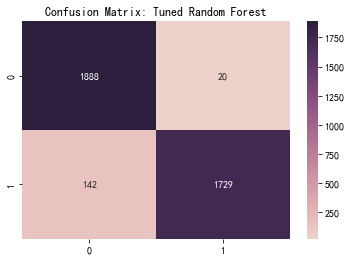

Feature: 0, Score: 0.06983
Feature: 1, Score: 0.09000
Feature: 2, Score: 0.00216
Feature: 3, Score: 0.10249
Feature: 4, Score: 0.00769
Feature: 5, Score: 0.00711
Feature: 6, Score: 0.02270
Feature: 7, Score: 0.04871
Feature: 8, Score: 0.00505
Feature: 9, Score: 0.07184
Feature: 10, Score: 0.04305
Feature: 11, Score: 0.04818
Feature: 12, Score: 0.02522
Feature: 13, Score: 0.08344
Feature: 14, Score: 0.05971
Feature: 15, Score: 0.07250
Feature: 16, Score: 0.05356
Feature: 17, Score: 0.09898
Feature: 18, Score: 0.08778


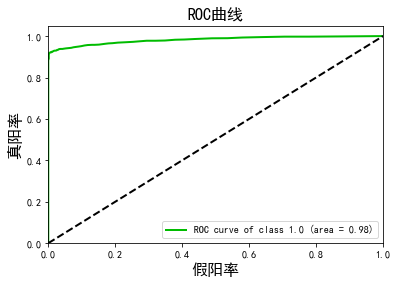

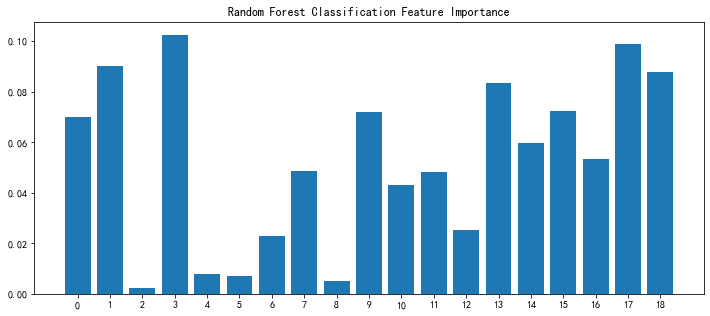


#######################################################
#######################################################

[21:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model:  XG Boost
Validation Accuracy:  0.9515744906059804
Training Accuracy:  0.992920002646728


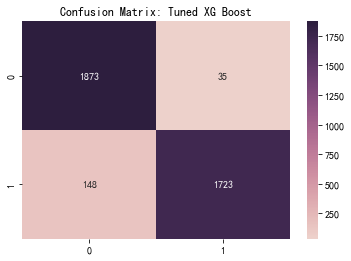

Feature: 0, Score: 0.03198
Feature: 1, Score: 0.09542
Feature: 2, Score: 0.01277
Feature: 3, Score: 0.00526
Feature: 4, Score: 0.00284
Feature: 5, Score: 0.00359
Feature: 6, Score: 0.00595
Feature: 7, Score: 0.15184
Feature: 8, Score: 0.05304
Feature: 9, Score: 0.04544
Feature: 10, Score: 0.11603
Feature: 11, Score: 0.13401
Feature: 12, Score: 0.00696
Feature: 13, Score: 0.06197
Feature: 14, Score: 0.10133
Feature: 15, Score: 0.03249
Feature: 16, Score: 0.13073
Feature: 17, Score: 0.00448
Feature: 18, Score: 0.00385


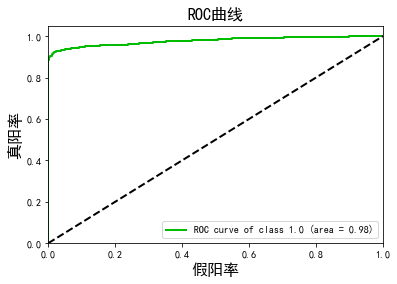

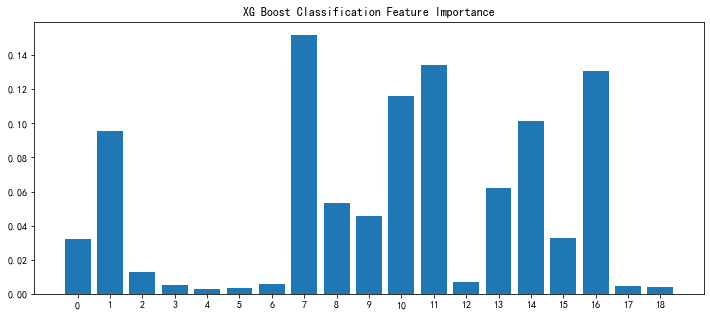


#######################################################
#######################################################

Model:  Cat Boost
Validation Accuracy:  0.9534268324953692
Training Accuracy:  0.9778998213458612


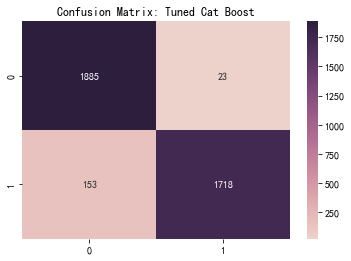

Feature: 0, Score: 6.70758
Feature: 1, Score: 5.76600
Feature: 2, Score: 0.05956
Feature: 3, Score: 4.85805
Feature: 4, Score: 0.29463
Feature: 5, Score: 0.24924
Feature: 6, Score: 1.39315
Feature: 7, Score: 5.15201
Feature: 8, Score: 0.49938
Feature: 9, Score: 12.83751
Feature: 10, Score: 6.00386
Feature: 11, Score: 5.54069
Feature: 12, Score: 0.95060
Feature: 13, Score: 12.15350
Feature: 14, Score: 8.26778
Feature: 15, Score: 13.12373
Feature: 16, Score: 7.79184
Feature: 17, Score: 4.57308
Feature: 18, Score: 3.77781


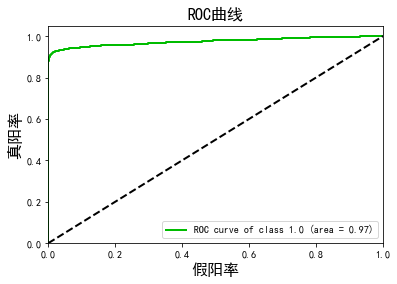

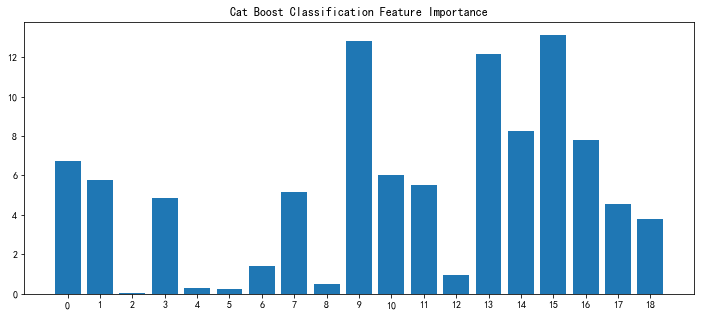


#######################################################
#######################################################



In [23]:
# The best three models with the best chosen parameters after tuning
models = [('Random Forest', RandomForestClassifier(criterion = 'gini', n_estimators = 100, random_state = 42)),
          ('XG Boost', XGBClassifier(max_depth = 7, min_child_weight = 1)),
          ('Cat Boost', CatBoostClassifier(max_depth = 7, n_estimators = 300, logging_level = 'Silent'))]

models_score = []
for name, model in models:
    model = model
    model.fit(x_train, y_train)
    model.predict(x_test)
    models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
    
    #print("Model: ",name)
    #print('Validation Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
    #print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
    
    plt.figure()
    cf_matrix = confusion_matrix(y_test, model.predict(x_test))
    plt.title('Confusion Matrix: Tuned {}'.format(name))
    sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
    plt.show()
    
    import scikitplot as skplt

    font1 = {'weight':'normal','size':16}
    skplt.metrics.plot_roc(y_test, model.predict_proba(x_test),
                         classes_to_plot=True,
                         figsize=(6, 4),
                        plot_micro=False, plot_macro=False)
    plt.title('ROC曲线',font1)
    plt.xlabel('假阳率',font1)
    plt.ylabel('真阳率',font1)
    plt.savefig("name{}.png".format(name),dpi=200)
    
    
    importance = model.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.figure(figsize = (12, 5))
    plt.bar([x for x in range(len(importance))], importance)
    plt.title("{} Classification Feature Importance".format(name))
    plt.xticks(range(0, 19))
    plt.show()
    print('')
    print('#######################################################')
    print('#######################################################')
    print('')